# Dynamic Mode Decomposition (DMD)

In this section, we forecast EEG activity using a DMD model, which extracts the dominant spatiotemporal modes of a system by finding the best-fit linear operator that evolves the signal forward in time. This algorithm can be conceputalized as a combination of the dimensionality reduction of PCA with the spectral analysis of a Fourier Transform, making it well suited for capturing state changes in neural activity.

## Background

DMD is a powerful factorization and dimensionality reduction technique designed for sequential data containing complex (non)linear dynamics (Schmid, 2022). At its core, it decomposes a univariate or multivariate time series into a set of interpretable spatial modes and scalar amplitudes that describe its spectral properties. When linearly combined, these parameters reconstruct the original signal and allow us to project the system’s state into the future.

In contrast to traditional dynamical system models, DMD does not attempt to extract governing equations by linearizing perturbations near an equilibrium point. Instead, it draws from Koopman operator theory and treats the data as a finite-dimensional "snapshot" of an underlying infinite-dimensional system, finding the best linear operator that captures the temporal evolution of these observables.

### Representing EEG Activity as a Dynamical System


Let $y_t \in \mathbb{R}^m$ represent the state of $m$ EEG channels at time $t$. DMD assumes that the "snapshot" $y_t$ is connected to the next snapshot $y_{t+1}$ by a linear mapping:

$$
y_{t+1} = \textbf{A}y_t \tag{1}
$$

where $\textbf{A} \in \mathbb{R}^{m \times m}$ describes the dynamics of the system. In an EEG experiment, measurements of this state are sampled at regular intervals of $\Delta t$. 

To solve for $\mathbf{A}$ using a data-driven approach, we gather a sequence of $k$ snapshots in time into the matrix $\mathbf{X}$. This matrix is then split into two $m \times (k-1)$ matrices: 

$$
\begin{align*}

\mathbf{X}_1 &= \begin{bmatrix}
\vert & \vert & & \vert \\
y_0 & y_1 & \cdots & y_{k-1} \\
\vert & \vert & & \vert 
\end{bmatrix},  \\\\

\mathbf{X}_2 &= \begin{bmatrix}
\vert & \vert & & \vert \\
y_1 & y_2 & \cdots & y_{k} \\
\vert & \vert & & \vert 
\end{bmatrix}. \tag{2}

\end{align*}
$$

Here, $\mathbf{X}_2$ is simply the matrix $\mathbf{X}_1$ shifted forward by one $\Delta t$. Following the logic of Equation (1), the linear operator $\mathbf{A}$ can be approximated by minimizing error in the following relationship: 

$$
\begin{align*}
\mathbf{X}_2 &= \mathbf{A}\mathbf{X}_1 \\
\mathbf{A} &= \mathbf{X}_2 \mathbf{X}_1^{\dagger} \tag{4}
\end{align*}
$$

where $^{\dagger}$ is the Moores-Penrose pseudoinverse. 

### DMD Algorithm

Often, the snapshot matrix $\mathbf{X}_1$ is high-dimensional, making its Moore-Penrose pseudoinverse computationally expensive to calculate directly. This is a common hurdle in EEG research, where recordings from 64 to 128 electrodes create wide snapshot matrices. To circumvent this, we utilize the Singular Value Decomposition (SVD) to project the data into a lower-dimensional subspace:

$$
\mathbf{X}_1 = U \Sigma V^{*}
$$

where $U \in \mathbb{R}^{m \times m}$ contains the spatial components, $\Sigma \in \mathbb{R}^{m \times (k-1)}$ contains the singular values, $V^{*} \in \mathbb{R}^{(k-1) \times (k-1)}$ contains the temporal components, and $^{*}$ denotes the complex conjugate transpose.

To filter noise and reduce complexity, we truncate these matrices based on the singular value threshold $r$:

$$
\mathbf{X}_1 \approx U_r \Sigma_r V^*_r
$$

where $U_r \in \mathbb{R}^{m \times r}$, $\Sigma_r \in \mathbb{R}^{r \times r}$, and $V_r^* \in \mathbb{R}^{r \times (k-1)}$. While several methods exist for choosing $r$, the Gavish and Donoho (2014) algorithm provides an optimal hard threshold for matrices containing noise. By working in this reduced space, we can compute a low-rank approximation of the dynamics $\mathbf{\tilde{A}} \in \mathbb{R}^{r \times r}$ much more efficiently:

$$
\mathbf{\tilde{A}} \approx U^*_r \mathbf{X}_2 V_r \Sigma_r^{-1}  \tag{5}
$$
 

Once we have $\mathbf{\tilde{A}}$, we perform an eigendecomposition to derive the dynamic modes and eigenvalues of the system:

$$
\begin{align*}
\mathbf{\tilde{A}} \mathbf{W} &= \mathbf{W} \mathbf{\Lambda} \\
\mathbf{\Phi} &= \mathbf{X}_2 V_r \Sigma_r^{-1} W \tag{6}
\end{align*}
$$

where $\mathbf{W}$ is a matrix of eigenvectors, $\mathbf{\Phi}$ is a matrix whose columns are the DMD modes $\phi_i$, and $\mathbf{\Lambda}$ is a diagonal matrix containing the DMD eigenvalues $\lambda_i$ that represent the growth/decay rates for each $\phi_i$. Note, the eigenvalues of $\mathbf{A}$ and $\mathbf{\tilde{A}}$ are equivalent and the eigenvectors are related via a linear tranform (Schmid, Meyer, & Pust, 2009; Proctor, Brunton, & Kutz, 2014).

To turn the DMD modes back into a time series, we first determine the initial weight or amplitude $\xi$ using the initial state $y_1$ and $\mathbf{\Phi}$:

$$
\begin{align*}
\xi &= \mathbf{\Phi}^\dagger y_0 \tag{7}
\end{align*}
$$

The temporal evolution of these modes is captured by a Vandermonde matrix ($\mathbf{C}$), which applies the eigenvalues $\lambda_i$ across time steps: 

$$
\mathbf{C} = \begin{bmatrix}
1 & \lambda_1 & \lambda_2^2 & \cdots & \lambda_1^{k-1} \\\\
1 & \lambda_2 & \lambda_2^2 & \cdots & \lambda_2^{k-1} \\
\vdots & \vdots & \vdots & & \vdots \\
1 & \lambda_r & \lambda_r^{2} & \cdots & \lambda_r^{k-1}
\end{bmatrix}
$$

Finally, we reconstruct an approximation of the original snapshot matrix $\mathbf{\hat{X}}$ as the product of the modes, their amplitudes, and their temporal evolution:

$$
\mathbf{\hat{X}} = \mathbf{\Phi} \text{diag}(\xi) \mathbf{C} \tag{8}
$$

Because $\mathbf{C}$ is a function of the discrete time step $k$, forecasting the next $h$ snapshots is accomplished by extending the Vandermonde matrix and adding columns for $k, k+1, \dots, k+h$.

### Link between DMD and Koopman Operator Theory

Standard DMD focuses on estimating a linear mapping between snapshots of the raw EEG signal $y$. However, this linear mapping is likely a poor representation of the temporal evolution of neural states that progress in a nonlinear fashion:

$$
y_{t+1} = \mathcal{F}(y_t)
$$

where $\mathcal{F}$ represents the nonlinear governing equations of the system. This mapping often stems from the discretization of partial differential equations that describe key features of state changes in neural activity, and identifying $\mathcal{F}$ directly from noisy EEG data is challenging. Koopman analysis provides a data-driven approach to uncover these governing equations by tracing *observables* of $y$, which we denote as $g(y)$, as they evolve in time (Schmid et al., 2022).

Observables represent a projection of the state vector onto a new manifold using a set of potentially infinite-dimensional functions $g(\cdot)$. This process, known as "lifting", embeds $y$ into a space in which its change between time points is linear:

$$
g(y_{t+1}) = \mathcal{K}g(y_t)
$$

where $\mathcal{K}$ is called the Koopman operator. In this framework, we trade finite-dimensional nonlinear complexity for infinite-dimensional linear simplicity.

The true utility of the Koopman operator lies in its spectral decomposition. Just as we performed eigendecomposition on the autoregressive matrix $\mathbf{A}$, we can analyze the eigenvalues of the Koopman operator. These spectral components can be estimated by performing DMD on snapshot matrices containing the observables $g(y)$—an approach known as **Exact DMD** (Tu et al., 2014). By shifting our focus from the raw EEG signal to these observables, we gain a more robust window into the underlying neural dynamics. However, for these numerical results to be meaningful, the data must be linearly consistent. This means the set of observables we choose must be "rich" enough to span a subspace that remains invariant under the action of the Koopman operator. When this condition is met, the DMD modes and eigenvalues closely approximate their true Koopman counterparts. Ultimately, Koopman operator theory provides a framework for uncovering a set of modes, amplitudes, and eigenvalues that describe complex nonlinear dynamics of a system.

### Hankelization

A significant challenge in the application of Exact DMD to model a dynamical system is creating a "sufficiently rich" dictionary of observables whose subspace accurately approximates a set of Koopman modes, eigenfunctions, and eigenvalues (Williams, Rowley, & Kevrekids, 2015). Common lifting methods include Hermite polynomials, radial basis functions, discontinuous spectral elements, kernel functions, and deep learning networks (Li et al., 2017; Williams, Rowley, & Kevrekids, 2015; Curtis et al., 2023). One popular approach is to constructing augmented snapshot matrices by appending $(h-1)$ time-delayed measurements:

$$
\mathbf{X}_{1}^{aug} = \begin{bmatrix}
\vert & \vert &  & \vert \\
y_0 & y_1 & \cdots & y_{k-h} \\
\vert & \vert &  & \vert \\
\vert & \vert &  & \vert \\
y_1 & y_2 & \cdots & y_{k-h+1} \\
\vert & \vert &  & \vert \\
& & \vdots &  & \\
\vert & \vert &  & \vert \\
y_h & y_h+1 & \cdots & y_{k-1} \\
\vert & \vert &  & \vert
\end{bmatrix}
$$

The same augmentation is applied to $\mathbf{X}_2$ to construct $\mathbf{X}_{2}^{aug}$. hese augmented snapshot matrices have a Hankel structure, often referred to as time-delay embeddings. This approach yields an intrinsic coordinate system that is hypothesized to form an approximate invariant subspace for the Koopman operator. By increasing the dimensionality through these temporal delays, we allow the linear DMD algorithm to resolve complex, nonlinear dependencies that are typically invisible in a single, raw snapshot.

Crucially, this methodology is mathematically robust for ergodic systems (Arbabi & Mezic, 2017). For systems that explore their entire available state space over time, delay embeddings provide a reliable way to recover the true spectral properties of the Koopman operator from measurements alone. For EEG forecasting, this means the historical memory contained in the Hankel matrix allows the model to reconstruct the broader dynamical landscape of the brain and project state changes forward with significantly higher fidelity. Indeed, prior work has shown that applying DMD to hankelized snapshot matrices successfully reconstructs snapshot matrices and produces a DMD mode spectrum that parallels spectral analysis using a discrete Fourier transform (Brunton et al., 2016). 

Although using hankelization simplifies the process of constructing a sufficiently rich set of observables, it still requires identification of an optimal time delay $h$. Takens' embedding theorem advises that Hankel matrices have a minimum of $(2d+1)$ rows in order to unfold a $d$-dimensional attractor into a space where its topology is presevered, yet this requires a priori knowledge of the attractor's structure. Instead, we will use a simple grid search to identify a delay that minimizes the reconstruction error (e.g., $\left\|\mathbf{X} - \mathbf{\hat{X}}\right\|^{2}$ ).

## Implementing DMD

Now lets put theory into practice. There are some open-source packages for implementing DMD and its various adaptations in a computationally efficient manner (e.g., [PyDMD](https://github.com/PyDMD/PyDMD)), but we are going to use custom code to gain a deeper intuition into how the algorithm works.

In [1]:
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from utils import OptimalSVHT
from tqdm import trange

First we will define a class for the DMD model. Following scikit-learn best practices, we are going to implement `fit`, `predict`, and `score` methods incase we want to use a built-in optimization algorithm.

In [2]:
class DMD:

    def __init__(self, dt, time_delay=0, svd_threshold='optimal', scale_modes=False, clip_lambda=False):
        """
        Dynamic Mode Decomposition (DMD).
        
        Parameters:
        - dt: Sampling period (1/Fs).
        - time_delay: Number of 'memory' stacks for Hankelization (h). 
                      Setting time_delay > 0 lifts the data with Hankel and implements the Extend DMD algorithm default=0 (no delays).
        - svd_threshold: Strategy to truncate noise ('optimal', cumulative float, or None).
        - scale_modes: If True, balances the A matrix using singular values.
        - clip_lambda: If True, forces eigenvalues into the unit circle for stability.
        """
        super().__init__()

        self.dt = dt
        self.svd_threshold=svd_threshold 
        self.scale_modes = scale_modes
        self.clip_lambda = clip_lambda
        self.time_delay = time_delay 

    def fit(self, X, y=None):
        """
        Fits the DMD model to the data matrix X.
        X shape: (n_channels, n_snapshots)
        """

        # Store original dimensions
        m, k = X.shape

        self.m = m
        self.k = k

        # Hankelization
        if self.time_delay:
            X = self.time_delay_embedding(X, self.time_delay)

        # Split data
        X1, X2 = X[:, :-1], X[:, 1:]
            

        # Get shape of matrices after hankel and split
        m, k = X1.shape

        # Decompose X1 
        U, s, Vh = linalg.svd(X1, full_matrices=False)
        V = Vh.conj().T
        S = np.diag(s)

        # Save unthresholded singular values
        self.singular_values = s

        # Reduce dimensionality of the data
        svd_threshold = self.svd_threshold

        if svd_threshold == 'optimal':
            # use optimal svd threshold if a threshold has not been provided
            beta_ratio = m / k
            if beta_ratio > 1:
                beta_ratio = 1/beta_ratio

            thresholder = OptimalSVHT(sigma_known=False) # based on Gavish & Donoho (2014)
            
            thresh = thresholder.compute_optimal_SVHT_coef(beta_ratio)* np.median(s)
            r = (S > thresh).sum().astype(int)

        elif isinstance(svd_threshold, float) and 0 < svd_threshold < 1:
            # use cumlative energy
            s_squared = s**2
            cumulative_energy = np.cumsum(s_squared) / (np.sum(s_squared))
            r = np.argmax(cumulative_energy > svd_threshold) + 1

        elif svd_threshold == None:
            # keep all of the singular values
            r = U.shape[-1]

        # store rank for traceability
        self.svd_rank = r

        # Truncate
        U_r = U[:, :r]
        V_r = V[:, :r]
        S_r = S[:r, :r]

        # Estimate A matrix
        A = U_r.conj().T @ X2 @ V_r @ linalg.inv(S_r) 

        if self.scale_modes:
           # scale modes by singular values to get corresponding energy for DMD spectrum (Brunton et al., 2016)
           A = np.diag(np.diag(S_r)**(-1/2)) @ A @ np.diag(np.diag(S_r)**(1/2))

        # eigen decomposition
        lamda, W = linalg.eig(A)

        # clip eigenvalues to unit circle for stability
        if self.clip_lambda:
            self.lamda_uncliped = lamda
            max_mag = 1.0
            lamda_clipped = np.where(np.abs(lamda) > max_mag, lamda/np.abs(lamda)*max_mag, lamda)
            lamda = lamda_clipped
        
        if self.scale_modes:
            W = S_r**(1/2) @ W

        # Estimate DMD modes
        Phi = X2 @ V_r @ linalg.inv(S_r) @ W

        # Estimate amplitudes
        b = linalg.pinv(Phi) @ X1[:, 0]

        # Truncate Phi if used hankel and keep original m rows
        Phi = Phi[:self.m,:]
        
        # store modes, amplitudes, and eigenvalues
        self.modes = Phi
        self.eigs = lamda
        self.amplitudes = b
        self.omega = np.log(lamda) / self.dt
        self.mode_hz = abs(np.imag(self.omega)/2/np.pi)

        return self

    def predict(self, start=0, end=None):
        """
        Reconstructs and/or forecast the time series using the learned DMD modes.
        -start: start index
        -end: end index. If None, then reconstructs original time series (default=None)
        """
        if end is None:
            end = self.k
        
        # construct vandermode matrix
        t_pows = np.tile(
            np.arange(start, end),
            (self.amplitudes.shape[0], 1)
            )
        
        C = self.eigs[:, np.newaxis] ** t_pows

        # time dynamics
        Z = np.diag(self.amplitudes) @ C

        self.time_dynamics = Z

        # reconstruct original data
        X_hat = (self.modes @ Z).real
    
        return X_hat
    
    def score(self, X, y=None):
        """
        Evaluates reconstruction accuracy using Mean Squared Error (MSE).
        """
        X_hat = self.predict(start=0, end=X.shape[-1])
        mse = np.mean((X - X_hat)**2)
        return mse

    @staticmethod
    def time_delay_embedding(X, h):
        """
        Performs Hankelization by stacking time-delayed snapshots.
        X: array of shape (m, k)
        h: number of delays
        Returns: array of shape (m*h, k-h+1)
        """

        m, k = X.shape

        if h > k:
            raise ValueError("h must be <= number of time steps")

        delayed = [X[:, i:k-h+i+1] for i in range(h)]
        X_aug = np.vstack(delayed)


        return X_aug

Great! Now we are going to apply this to our EEG data. As a brief recap, this data comes from a study mapping steady state visual evoked potentials (SSVEPs) across various frequency bands (Gu et al., 2024). This makes it perfect for DMD, since SSVEPs contain a strong oscillatory component. For this analysis, we will focus on a single trial during which the presented stimulus flickered at 10 Hz.

In [3]:
# load single subject from Gu et al., 2024 SSVEP experiment
# Note, data has been downsampled to 250 Hz
data = np.load('../Data/Gu et al., 2024/data_s1_64_down.npy')

In [ ]:
# block x stimulation frequency x time x channels x conditions (i.e., modulation depths; low and high luminance ratios)
# stimulation frequencies are from 1-60 in increments of 1 Hz
nBlocks, nFreqs, nTime, nChans, nCons = data.shape

# extract a single set of time series for 10 Hz stimulation
# transpose to make channels x time
trial_idx = 0
stim_idx = 9
X = data[trial_idx, stim_idx, :, :, 1].T

# SSVEPs are typically localized over the P-PO-O electrodes 
ssvep_chan_names = ['Pz', 'PO5', 'PO3', 'POz', 'PO4', 'PO6', 'O1', 'Oz', 'O2']
ssvep_chans_idx = [48,54,55,56,57,58,61,62,63]

ssvep_chans_dict = dict(zip(ssvep_chan_names, ssvep_chans_idx))

In [5]:
# construct time vector. Stimulation time is 5s, and epochs included 0.14s post stimulus offset
Fs = 250.
t = np.arange(0, 5.14, 1/Fs) * 1000

Now lets visualize the data to get a sense of its structure (i.e., trend, seasonality, non-stationarity, etc.):

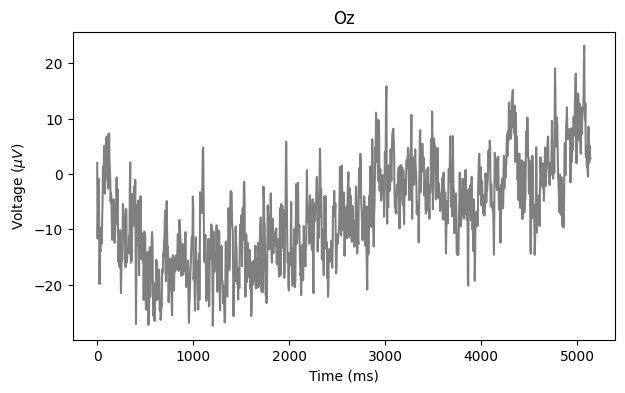

In [6]:
plt.figure(figsize=(7,4))
plt.plot(t, X[ssvep_chans_dict['Oz'], :], color='k', alpha=0.5)
plt.xlabel('Time (ms)')
plt.ylabel(r'Voltage ($\mu V$)')
plt.title('Oz')
plt.show()

Looking at activity from a single electrode, we see immediately it is non-stationarity and contains a steep linear trend. While DMD can technically process this data, it is built on an autoregressive framework that assumes the underlying rules of the system remain constant over time. A linear trend acts as a 'moving target' for the algorithm, forcing it to waste its energy modeling a shifting baseline rather than the actual oscillatory components we want to isolate.

Lets remove the linear trend:

In [7]:
# Construct design matrix using time as a covariate w/ an intercept
time_design_matrix = np.vstack([np.ones(nTime), np.arange(nTime)])

In [8]:
# Estimate the trend. Using custom code incase we want to add the trend back in later
beta, _, _, _ = linalg.lstsq(time_design_matrix.T, X.T)
trend = (time_design_matrix.T @ beta).T

In [9]:
# Detrend the time series
X_detrended = X - trend

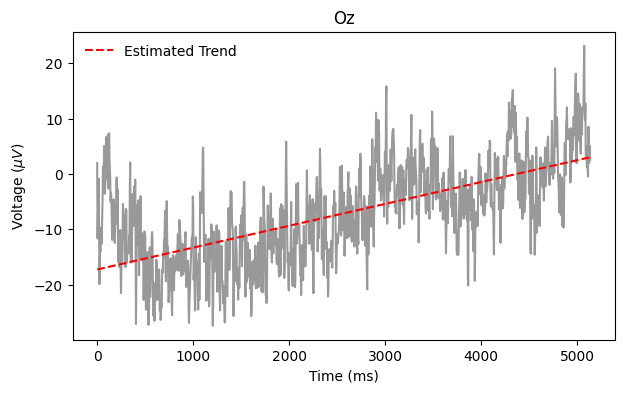

In [10]:
# Visualize Raw vs Trend
plt.figure(figsize=(7,4))
plt.plot(t, X[ssvep_chans_dict['Oz'], :], color='k', alpha=0.4)
plt.plot(t, trend[ssvep_chans_dict['Oz'], :], color='r', linestyle='--', label='Estimated Trend')
plt.xlabel('Time (ms)')
plt.ylabel(r'Voltage ($\mu V$)')
plt.title('Oz')
plt.legend(frameon=False)
plt.show()

In [11]:
# Demean and scale the data for SVD (similar to PCA)
X_centered = (X_detrended - X_detrended.mean(axis=-1, keepdims=True)) / X_detrended.std(axis=-1, keepdims=True)

In [12]:
# construct the model
dmd = DMD(
    dt=1/Fs, 
    scale_modes=True, 
    clip_lambda=True, 
    svd_threshold=0.999
)

Next we are going to perform a grid search for the optimal delay. Though the object is compatible with scitkit-learn optimization algorithms, we will just use a simple for loop tracking AIC, BIC, SVD rank, and reconstruction MSE:

In [13]:
# Define bounds of time delays to search over
time_delays = np.arange(50,300,10)
nDelays = len(time_delays)

In [14]:
reconstruction_errors = np.zeros(nDelays)
aics = np.zeros(nDelays)
bics = np.zeros(nDelays)
ranks = np.zeros(nDelays)
total_observations = X_centered.size
for i in trange(nDelays):
    dmd.time_delay = time_delays[i]

    dmd.fit(X_centered)
    mse = dmd.score(X_centered)

    nModes = dmd.modes.shape[0]
    # track rank to check if model is capturing more noise as delays increase, or if rank is roughly the same
    ranks[i] = dmd.svd_rank
    n_free_parameters = nModes * (2 * nChans + 1)

    # compute information criterion metrics to ensure not overfitting
    aic = 2*n_free_parameters + total_observations * np.log(mse)
    bic = n_free_parameters * np.log(total_observations) + total_observations * np.log(mse)

    reconstruction_errors[i] = mse
    aics[i] = aic
    bics[i] = bic

100%|██████████| 25/25 [07:36<00:00, 18.26s/it]


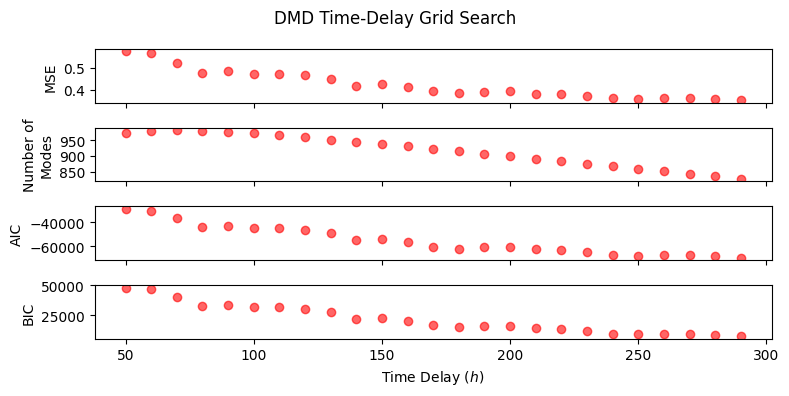

In [15]:
fig, ax = plt.subplots(nrows=4, figsize=(8,4), sharex=True, dpi=100)
ax[0].scatter(time_delays, reconstruction_errors, color='r', alpha=0.6)
ax[0].set_ylabel('MSE')

ax[1].scatter(time_delays, ranks, color='r', alpha=0.6)
ax[1].set_ylabel('Number of\nModes')

ax[2].scatter(time_delays, aics, color='r', alpha=0.6)
ax[2].set_ylabel('AIC')

ax[3].scatter(time_delays, bics, color='r', alpha=0.6)
ax[3].set_ylabel('BIC')
ax[3].set_xlabel('Time Delay ($h$)')

plt.suptitle('DMD Time-Delay Grid Search')
plt.tight_layout()
plt.show()

Looking at the results of our grid search, it appears as though all of our metrics of performance decrease as delay increases. This suggests that as the model becomes more complex, it is capturing more dynamics instead of just noise. We will use the minimum MSE to select the best delay, then using the optimal SVD threshold to reduce the dimensionality of the model further.

In [16]:
optimal_delay = time_delays[reconstruction_errors.argmin()]
print(f'Best Time Delay: {optimal_delay}')

Best Time Delay: 290


In [17]:
# change time delay and svd threshold
dmd.time_delay = optimal_delay
dmd.svd_threshold = 'optimal'

In [18]:
# refit the model
dmd.fit(X_centered)

In [19]:
# Reconstruct the original data
X_hat = dmd.predict()

Now lets take a look at our reconstruction:

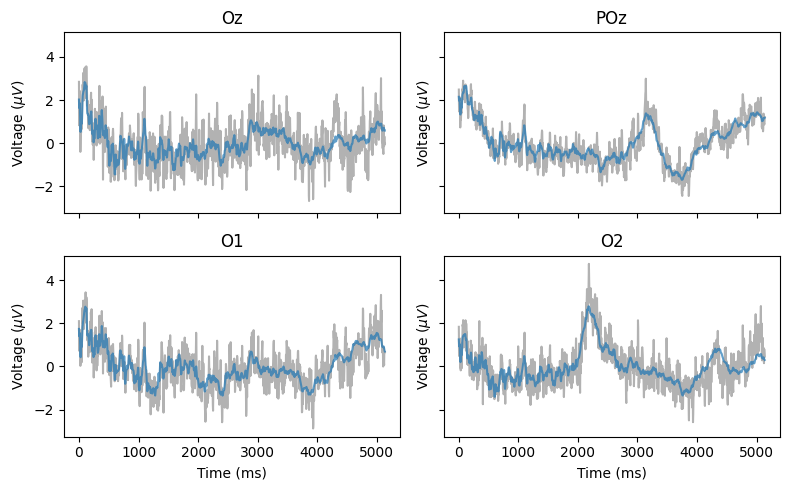

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 5), dpi=100, sharex=True, sharey=True)

axs = axs.ravel()
for i, c in enumerate(['Oz', 'POz', 'O1', 'O2']):

    axs[i].plot(t, X_centered[ssvep_chans_dict[c], :], color='k', alpha=0.3)
    axs[i].plot(t, X_hat[ssvep_chans_dict[c], :], alpha=0.7)
    axs[i].set_title(c)

    if i > 1:
        axs[i].set_xlabel('Time (ms)')

    axs[i].set_ylabel(r'Voltage ($\mu V$)')

plt.tight_layout()
plt.show()

We can see the model did a decent job at reconstructing the general shape of the activity across multiple electrodes, while also ignoring sharp amplitude impulses that could be reflective of noise.

Lets take a look at the DMD mode spectrum to get an idea of which oscillations are driving activity in this trial. We'll compare this spectrum to a discrete fourier transform (DFT) that is a conventional approach for time-frequency analysis of EEG data

In [42]:
# isolate unique modes caused by +/- eigenvalue pairs
unique_mode_freqs, unique_idx = np.unique(np.round(dmd.mode_hz, 2), return_index=True)
unique_modes = dmd.modes[:, unique_idx]

unique_time_dynamics = dmd.time_dynamics[unique_idx, :]

In [22]:
# Compute mode power (Brunton et al., 2016)
modes_power = np.diag(unique_modes.conj().T @ unique_modes)

Compute DFT:

In [23]:
# Time series length is massive so do Fs * 5
NFFT = 250*5

In [24]:
# Compute FFT
spectra = np.fft.rfft(X_centered, NFFT, axis=-1) / nTime

In [25]:
# Extract frequencies of interest
freqs = np.fft.rfftfreq(NFFT, 1/Fs)
keep_idx = np.arange(np.argmin(abs(freqs-1)), np.argmin(abs(freqs-65)))

freqs = freqs[keep_idx]
spectra = spectra[:, keep_idx]

In [26]:
# Compute power
pow = abs(spectra**2)

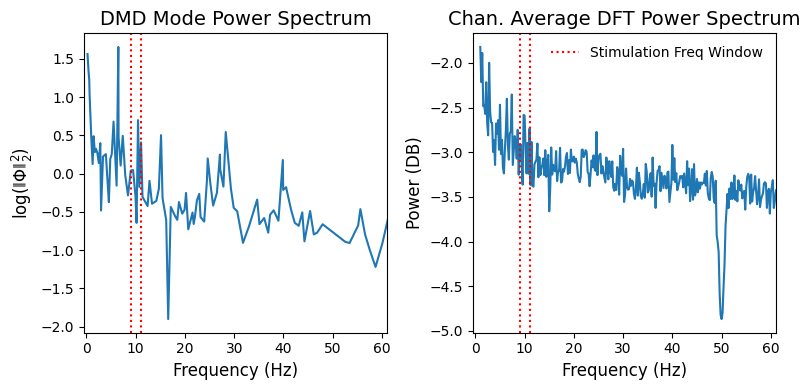

In [27]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4), dpi=100)

ax[0].plot(unique_mode_freqs, np.log(modes_power.real))
ax[0].set_xlabel('Frequency (Hz)', fontsize=12)
ax[0].set_ylabel(r'$\log(\left\| \Phi \right\|_{2}^{2})$', fontsize=12)
ax[0].set_title('DMD Mode Power Spectrum', fontsize=14)

#plt.xlim(-1, 61) 

# highlight stimulation frequency
ax[0].axvline(9, color='red', linestyle=':')
ax[0].axvline(11, color='red', linestyle=':')
ax[0].set_xlim(-0.5, 61)

# Average power across all electrodes
ax[1].plot(freqs, np.log10(pow.mean(axis=0)))
ax[1].set_xlabel('Frequency (Hz)', fontsize=12)
ax[1].set_ylabel(r'Power (DB)', fontsize=12)
ax[1].axvline(9, color='red', linestyle=':', label='Stimulation Freq Window')
ax[1].axvline(11, color='red', linestyle=':')
ax[1].set_xlim(-0.5, 61)
ax[1].set_title('Chan. Average DFT Power Spectrum', fontsize=14)
ax[1].legend(frameon=False)

plt.tight_layout()
plt.show()

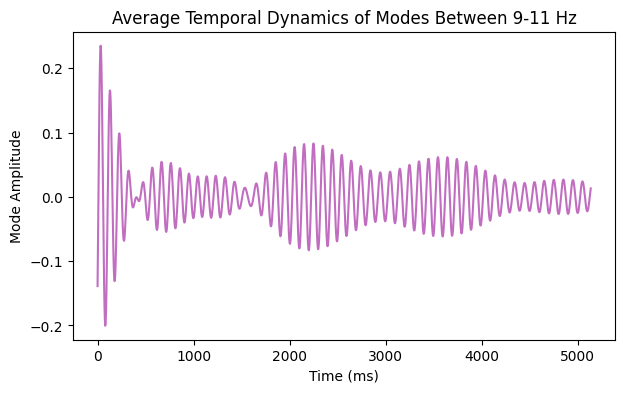

In [84]:
# plot modes around 10 Hz over time
modes_of_interest_idx = np.argwhere((9 < unique_mode_freqs) & (unique_mode_freqs < 11))

plt.figure(figsize=(7, 4))
plt.plot(t, unique_time_dynamics[modes_of_interest_idx, :].real.mean(axis=0).squeeze(), color=[0.6, 0.05, 0.6, 0.6])
plt.ylabel('Mode Amplitude')
plt.xlabel('Time (ms)')
plt.title('Average Temporal Dynamics of Modes Between 9-11 Hz')
plt.show()

Both spectograms show a peak at the stimulation frequency of 10 Hz. Note, DMD yielded a mode with a frequence of 10.47 Hz, hence why it is shifted off-center in the $\pm 1$ Hz window around the center stimulation frequency. Though these plots may look similar, its important to remember that DMD is estimating dominant modes based on the spatial correlations across channels, while DFT is computed independently for each channel and then averaged. Interestingly, DMD also yielded a dominant 6.47 Hz component with a larger magnitude than the stimulation frequency. This could be due to the use of hankelization to create more structure in the time-shifted matrices, or be an actual brain component. We would need the electrode position file and to plot the togopraphic distribution of the mode to determine whether it is signal or noise.
Looking at the average temporal dynamics (i.e., product of the Vandermode matrix of DMD eigenvalues and mode amplitudes) for DMD modes with frequencies between 9-11 Hz, we see an initial sharp increase in amplitude at stimulus onset (0 ms) followed by three bursts with the largest ~2000 ms.  

Next lets focus on forecasting the data. Instead of fitting the model to the full trial, we will only fit it to the first 3000 ms. Then, we will forecast the last 1000 ms.

In [109]:
train_end = abs(t-3000).argmin()

X_train, X_test = X_centered[:, :train_end], X_centered[:, train_end:]

In [111]:
dmd.svd_threshold = 0.99

In [131]:
reconstruction_errors = np.zeros(nDelays)
for i in trange(nDelays):
    dmd.time_delay = time_delays[i]

    dmd.fit(X_train)
    X_hat = dmd.predict(start=0, end=X_train.shape[-1]) # reconstruct initial sequence
    mse = np.mean((X_train - X_hat)**2)

    reconstruction_errors[i] = mse

100%|██████████| 25/25 [01:03<00:00,  2.53s/it]


In [132]:
# Select the best delay
optimal_delay = time_delays[reconstruction_errors.argmin()]
print(f'Best Time Delay: {optimal_delay}')

Best Time Delay: 180


In [133]:
dmd.time_delay = optimal_delay
dmd.svd_threshold = 'optimal'

In [134]:
dmd.fit(X_centered)

In [135]:
# Reconstruct initial time series and forecast 
forecast = dmd.predict(start=0, end=len(t))

In [136]:
# truncate to get just the forecasted time points
forecast = forecast[:, train_end:]

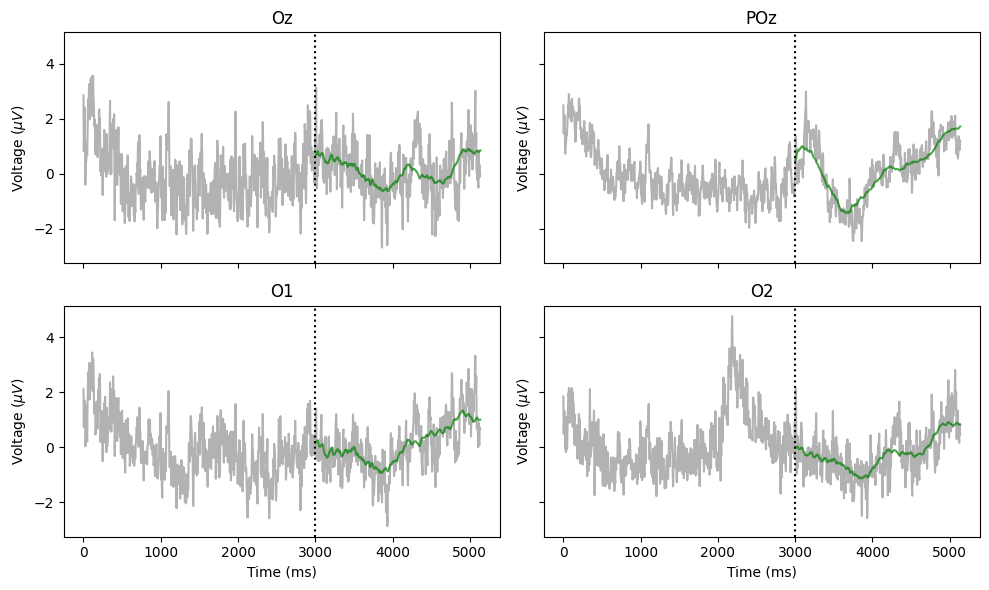

In [142]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), dpi=100, sharex=True, sharey=True)

axs = axs.ravel()
for i, c in enumerate(['Oz', 'POz', 'O1', 'O2']):

    axs[i].plot(t, X_centered[ssvep_chans_dict[c], :], color='k', alpha=0.3)
    axs[i].plot(t[train_end:], forecast[ssvep_chans_dict[c], :], color='g', alpha=0.7)
    axs[i].set_title(c)
    axs[i].axvline(t[train_end], color='black', linestyle=':', label='Train End')

    if i > 1:
        axs[i].set_xlabel('Time (ms)')

    axs[i].set_ylabel(r'Voltage ($\mu V$)')

    if i==3:
        ax[i].legend(frameon=False)

plt.tight_layout()
plt.show()

In [141]:
rmse = np.sqrt(((X_centered[:, train_end:] - forecast)**2).mean())
print(f'RMSE: {rmse:0.2f}')

RMSE: 0.76


Looking at a the forecasts for posterior electrodes, we see that Extended DMD does a fairly decent job at predicting activity 2 seconds in the future with a RMSE of 0.76. It does fail to capture potentially meaninfuly fluctuations in activity, such as the sharp increase in amplitude ~4000 ms, but otherwise it tracks the core structure of the time series. 

# Summary

DMD and its variants offer a powerful, data-driven framework for uncovering the dynamics of a complex time series. Unlike traditional methods that treat space and time separately, DMD identifies coupled spatiotemporal modes that are both interpretable and spectrally rich. Once these modes are identified, they form a generative model capable of forecasting the system’s trajectory.